# Naive Risk Budgeting Strategies between the PSP and the GHP

In [28]:
import numpy as np
import pandas as pd
import edhec_risk_kit as erk
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
def bt_mix(r1, r2, allocator, **kwargs):
    """
    Runs a back test (simulation) of allocating between a two sets of returns
    r1 and r2 are T x N dataframe or returns where T is the time step index and N is the number of scenarios
    Allocator is a function that takes two sets of returns and allocator specific parameters, an produces
    an allocation to the first portfolio (the rest of the money is invested in the GHP) as a T x 1 DataFrame
    Returns a T x N DataFrame  of the resulting N portfolio scenarios
    """
    if not r1.shape == r2.shape:
        raise ValueError("r1 and r2 need to be the same shape")
    weights = allocator(r1, r2, **kwargs)
    if not weights.shape == r1.shape:
        raise ValueError("Allocator returned weights that don't match r1")
    r_mix = weights*r1 + (1-weights)*r2
    return r_mix

In [40]:
def fixedmix_allocator(r1, r2, w1, **kwargs):
    """
    Produces a time series over T steps of allocations between the PSP and GHP across N scenarios
    PSP and GHP are T x N dataFrames that represent the returns of the PSP and GHP such that:
        each column is a scenario
        each row is the price for a timestep
    return an T x N DataFrame of the PSP weights
    """
    return pd.DataFrame(data=w1, index = r1.index, columns=r1.columns)

In [41]:
rates, zc_prices = erk.cir(10,500,b=0.03, r_0=0.03)
price_10 = erk.bonds_price(10, 100, .05, 12, rates)
price_30 = erk.bonds_price(30, 100, .05, 12, rates)
rets_30 = erk.bond_total_return(price_30, 100, .05, 12)
rets_10 = erk.bond_total_return(price_10, 100, .05, 12)
rets_bonds = bt_mix(rets_10, rets_30, allocator=fixedmix_allocator, w1=.6)
mean_rets_bonds = rets_bonds.mean(axis='columns')
erk.summary_stats(pd.DataFrame(mean_rets_bonds))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.035484,0.003558,0.241443,2.707409,-0.001293,-0.000999,1.500143,0.0


In [5]:
rates, zc_prices = erk.cir(10,500,b=0.03, r_0=0.03)
price_10 = erk.bonds_price(10, 100, .05, 12, rates)
price_30 = erk.bonds_price(30, 100, .05, 12, rates)
rets_30 = erk.bond_total_return(price_30, 100, .05, 12)
rets_10 = erk.bond_total_return(price_10, 100, .05, 12)
rets_bonds = erk.bt_mix(rets_10, rets_30, allocator=erk.fixedmix_allocator, w1=.6)
mean_rets_bonds = rets_bonds.mean(axis='columns')
erk.summary_stats(pd.DataFrame(mean_rets_bonds))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.036314,0.003243,0.420052,3.175382,-0.001562,-0.001224,1.895128,0.0


In [6]:
price_eq = erk.gbm(n_years=10, n_scenarios=500, mu=0.07, sigma=0.15)
rets_eq = price_eq.pct_change().dropna()
rets_zc = zc_prices.pct_change().dropna()

In [7]:
rets_7030b = erk.bt_mix(rets_eq, rets_bonds, allocator=erk.fixedmix_allocator, w1=0.7)
rets_7030b_mean = rets_7030b.mean(axis='columns')
erk.summary_stats(pd.DataFrame(rets_7030b_mean))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.058992,0.005016,0.147667,3.222035,-0.002485,-0.001792,5.625427,0.0


In [8]:
summaries = erk.summary_stats(rets_7030b)

In [9]:
summaries.head()

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.024162,0.109630,0.011627,2.650424,0.049469,0.059585,-0.051961,-0.201753
1,0.035938,0.112124,0.115702,2.898272,0.048552,0.061277,0.051410,-0.275847
2,0.043324,0.112898,-0.160714,3.126387,0.050700,0.067442,0.114726,-0.227951
3,0.054744,0.102396,-0.306043,3.304327,0.045860,0.061303,0.235069,-0.241731
4,0.062406,0.103267,0.367922,3.314696,0.039968,0.051306,0.305300,-0.161314


In [10]:
summaries.mean()

Annualized Return          0.053450
Annualized Vol             0.107702
Skewness                   0.001002
Kurtosis                   2.941041
Cornish-Fisher VaR (5%)    0.046139
Historic CVaR (5%)         0.058257
Sharpe Ratio               0.212494
Max Drawdown              -0.207815
dtype: float64

In [11]:
def terminal_values(rets):
    """
    Returns the final values of a dollat at the end of the return period for each scenario
    """
    return (rets+1).prod()


def terminal_stats(rets, floor=0.8, cap=np.inf, name="Stats"):
    """
    Produce the Summary Satistics on the terminal values per invester dollar
    across a range of N scenarios
    rets is a T x N DataFrame of returns, where T is the time-step (we assume rets is sorted by time)
    Returns a 1 column Dataframe of summary stats indexed by the stat name
    """
    terminal_wealth = (1+rets).prod()
    breach = terminal_wealth < floor
    reach = terminal_wealth >= cap
    p_breach = breach.mean() if breach.sum() > 0 else np.nan
    p_reach = reach.mean() if reach.sum() > 0 else np.nan
    e_short = (floor - terminal_wealth[breach]).mean() if breach.sum() > 0 else np.nan
    e_surplus = (cap - terminal_wealth[reach]).mean() if reach.sum() > 0 else np.nan
    sum_stats = pd.DataFrame.from_dict({
        "mean": terminal_wealth.mean(),
        "std": terminal_wealth.std(),
        "p_breach": p_breach ,
        "e_short": e_short, 
        "p_reach": p_reach,
        "e_surplus": e_surplus,
    }, orient = index, columns=[name])
    return sum_stats

In [24]:
pd.concat([
    erk.terminal_stats(rets_bonds, name="FI"), 
    erk.terminal_stats(rets_eq, name="Eq"),
    erk.terminal_stats(rets_7030b, name="70/30") 
], axis = 1)

,FI,Eq,70/30
mean,1.389881,1.934804,1.763705
std,0.104981,0.960420,0.592551
p_breach,NaN,0.048000,0.006000
e_short,NaN,0.097268,0.069893
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


C:\Users\gamou\AppData\Roaming\Python\Python36\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\gamou\AppData\Roaming\Python\Python36\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\gamou\AppData\Roaming\Python\Python36\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

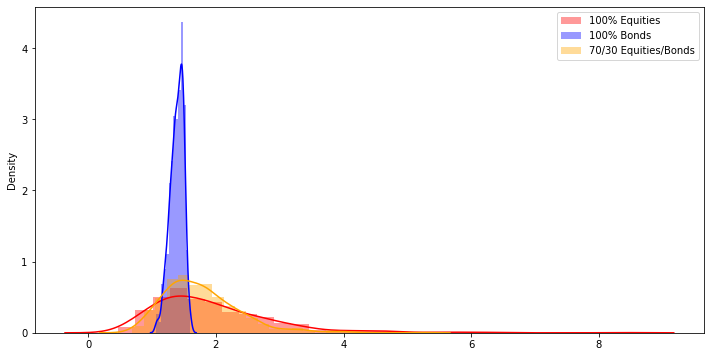

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
sns.distplot(erk.terminal_values(rets_eq), color="red", label="100% Equities")
sns.distplot(erk.terminal_values(rets_bonds), color="blue", label="100% Bonds")
sns.distplot(erk.terminal_values(rets_7030b), color="orange", label="70/30 Equities/Bonds")
plt.legend();

# Glide Paths for allocation

In [47]:
def glidepath_allocator(r1, r2, start_glide=1, end_glide=0, **kwargs):
    """
    Simulates a Target-Date-Fund style gradual move from r1 to r2
    """
    n_points = r1.shape[0]
    n_col = r1.shape[1]
    path = pd.Series(data = np.linspace(start_glide, end_glide, num=n_points))
    paths = pd.concat([path]*n_col, axis = 1)
    paths.index = r1.index
    path.columns = r1.columns
    return paths

In [43]:
pouf = glidepath_allocator(rets_eq, rets_bonds)
pouf

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,0.991597,0.991597,0.991597,0.991597,0.991597,0.991597,0.991597,0.991597,0.991597,0.991597,...,0.991597,0.991597,0.991597,0.991597,0.991597,0.991597,0.991597,0.991597,0.991597,0.991597
3,0.983193,0.983193,0.983193,0.983193,0.983193,0.983193,0.983193,0.983193,0.983193,0.983193,...,0.983193,0.983193,0.983193,0.983193,0.983193,0.983193,0.983193,0.983193,0.983193,0.983193
4,0.974790,0.974790,0.974790,0.974790,0.974790,0.974790,0.974790,0.974790,0.974790,0.974790,...,0.974790,0.974790,0.974790,0.974790,0.974790,0.974790,0.974790,0.974790,0.974790,0.974790
5,0.966387,0.966387,0.966387,0.966387,0.966387,0.966387,0.966387,0.966387,0.966387,0.966387,...,0.966387,0.966387,0.966387,0.966387,0.966387,0.966387,0.966387,0.966387,0.966387,0.966387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,0.033613,0.033613,0.033613,0.033613,0.033613,0.033613,0.033613,0.033613,0.033613,0.033613,...,0.033613,0.033613,0.033613,0.033613,0.033613,0.033613,0.033613,0.033613,0.033613,0.033613
117,0.025210,0.025210,0.025210,0.025210,0.025210,0.025210,0.025210,0.025210,0.025210,0.025210,...,0.025210,0.025210,0.025210,0.025210,0.025210,0.025210,0.025210,0.025210,0.025210,0.025210
118,0.016807,0.016807,0.016807,0.016807,0.016807,0.016807,0.016807,0.016807,0.016807,0.016807,...,0.016807,0.016807,0.016807,0.016807,0.016807,0.016807,0.016807,0.016807,0.016807,0.016807
119,0.008403,0.008403,0.008403,0.008403,0.008403,0.008403,0.008403,0.008403,0.008403,0.008403,...,0.008403,0.008403,0.008403,0.008403,0.008403,0.008403,0.008403,0.008403,0.008403,0.008403


In [36]:
pouf.shape

(120, 500)

In [52]:
rets_g8020 = erk.bt_mix(rets_eq, rets_bonds, allocator=erk.glidepath_allocator, start_glide=.80, end_glide=.20)
pd.concat([
    erk.terminal_stats(rets_bonds, name="FI"), 
    erk.terminal_stats(rets_eq, name="Eq"),
    erk.terminal_stats(rets_7030b, name="70/30"), 
    erk.terminal_stats(rets_g8020, name="Glide 80 to 20")
], axis = 1)

,FI,Eq,70/30,Glide 80 to 20
mean,1.378946,1.934804,1.763705,1.637030
std,0.106841,0.960420,0.592551,0.408035
p_breach,NaN,0.048000,0.006000,0.002000
e_short,NaN,0.097268,0.069893,0.161159
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN


C:\Users\gamou\AppData\Roaming\Python\Python36\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\gamou\AppData\Roaming\Python\Python36\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\gamou\AppData\Roaming\Python\Python36\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

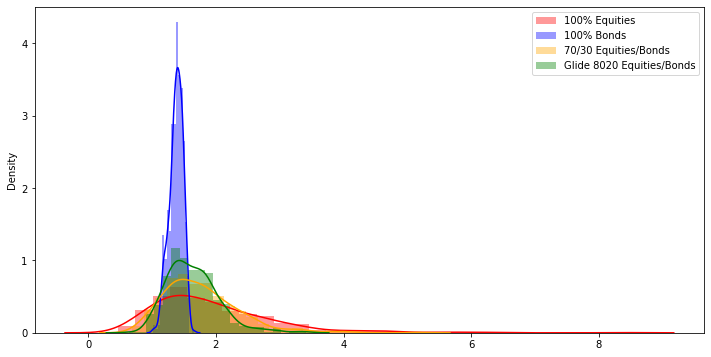

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
sns.distplot(erk.terminal_values(rets_eq), color="red", label="100% Equities")
sns.distplot(erk.terminal_values(rets_bonds), color="blue", label="100% Bonds")
sns.distplot(erk.terminal_values(rets_7030b), color="orange", label="70/30 Equities/Bonds")
sns.distplot(erk.terminal_values(rets_g8020), color="green", label="Glide 8020 Equities/Bonds")
plt.legend();

In [83]:
np.random.normal()


-0.6569566860624663